In [7]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from utility_visualisation import missing_values_barplot, remove_plot_ticks
from utility import TimeSeriesDataset, load_pickle, torch_ffill, shock_index, partial_sofa, RollingStatistic
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_predict, KFold
import numpy as np
import missingno as msno

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1552210 entries, 0 to 1552209
Data columns (total 44 columns):
 #   Column            Non-Null Count    Dtype  
---  ------            --------------    -----  
 0   id                1552210 non-null  int64  
 1   time              1552210 non-null  int64  
 2   HR                1398811 non-null  float64
 3   O2Sat             1349474 non-null  float64
 4   Temp              525226 non-null   float64
 5   SBP               1325945 non-null  float64
 6   MAP               1358940 non-null  float64
 7   DBP               1065656 non-null  float64
 8   Resp              1313875 non-null  float64
 9   EtCO2             57636 non-null    float64
 10  BaseExcess        84145 non-null    float64
 11  HCO3              65028 non-null    float64
 12  FiO2              129365 non-null   float64
 13  pH                107573 non-null   float64
 14  PaCO2             86301 non-null    float64
 15  SaO2              53561 non-null    float64
 16  

C:\Users\Jun Hua\anaconda3\envs\python_gpu\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


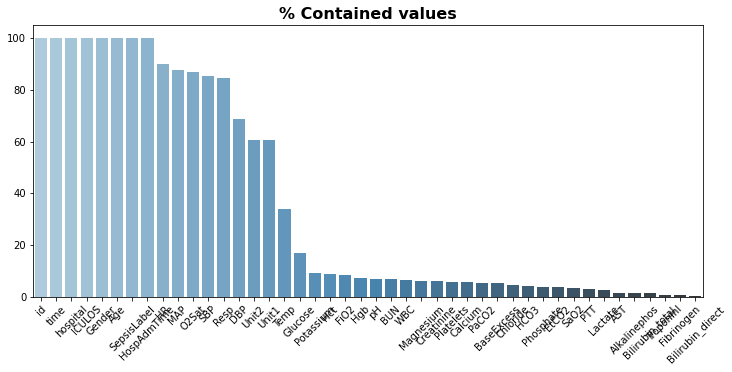

In [2]:
data_dir = './input'

# 1. Loading the dataset and perform quick inspection of data
df = load_pickle(data_dir + '/raw/df.pickle')
labels_binary = load_pickle(data_dir + '/processed/labels/binary.pickle')
labels_utility = load_pickle(data_dir + '/processed/labels/utility_scores.pickle')

df.head(5)
df.info()

missing_values_barplot(df, missing=False)


In [8]:
def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()
        
        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns

In [9]:
df_missing= missing_values_table(df)
df_missing

Your selected dataframe has 44 columns.
There are 37 columns that have missing values.


,Missing Values,% of Total Values
Bilirubin_direct,1549220,99.8
Fibrinogen,1541968,99.3
TroponinI,1537429,99.0
Bilirubin_total,1529069,98.5
Alkalinephos,1527269,98.4
AST,1527027,98.4
Lactate,1510764,97.3
PTT,1506511,97.1
SaO2,1498649,96.5
EtCO2,1494574,96.3


In [10]:
missing_data_col = df.columns[df.isna().any()].tolist()

<AxesSubplot:>

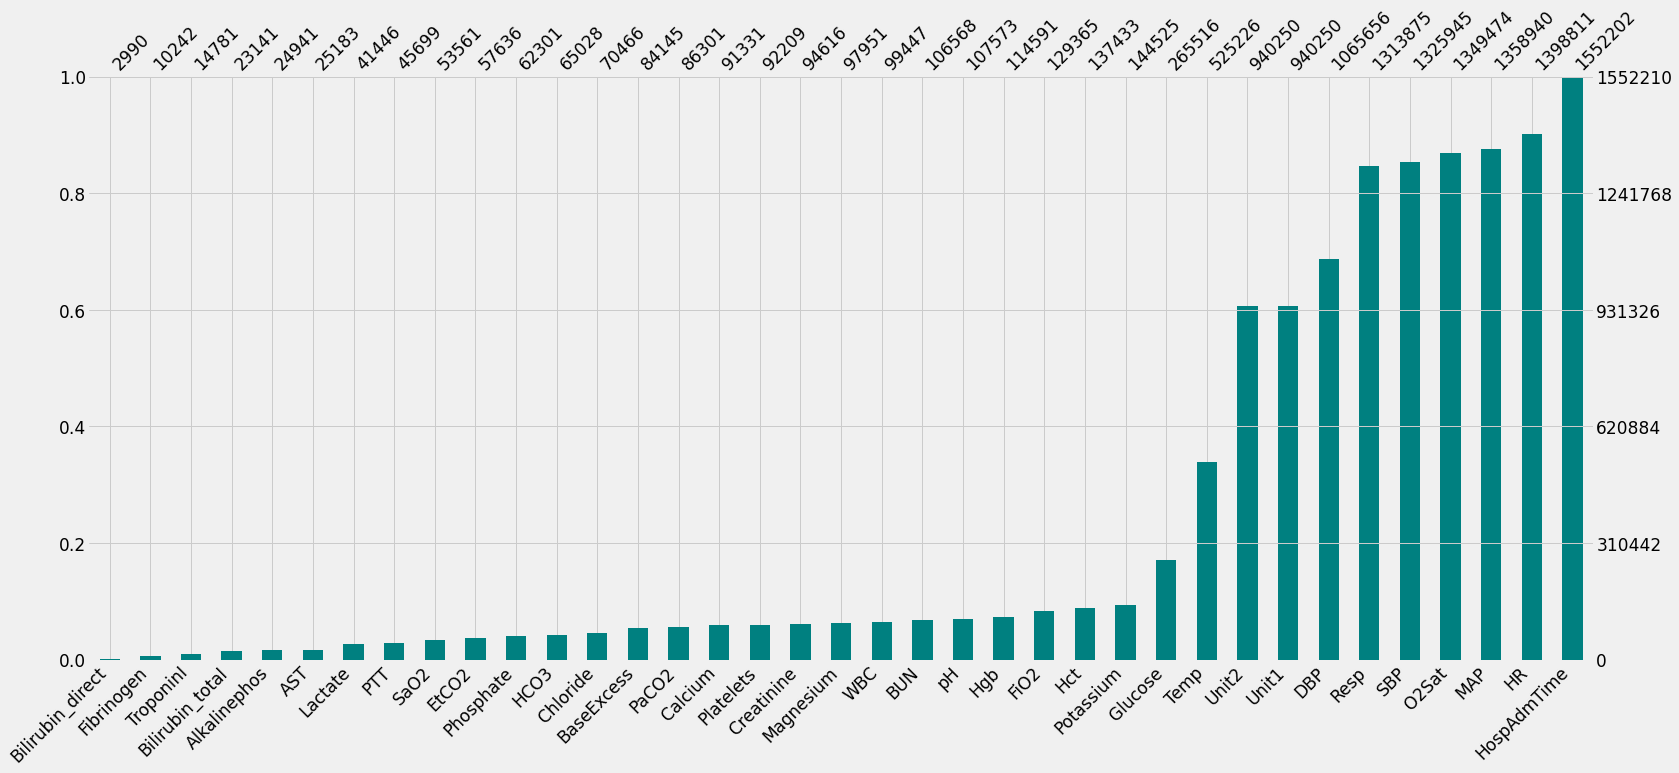

In [11]:
msno.bar(df[missing_data_col], color="teal", sort="ascending", fontsize=17)


<AxesSubplot:>

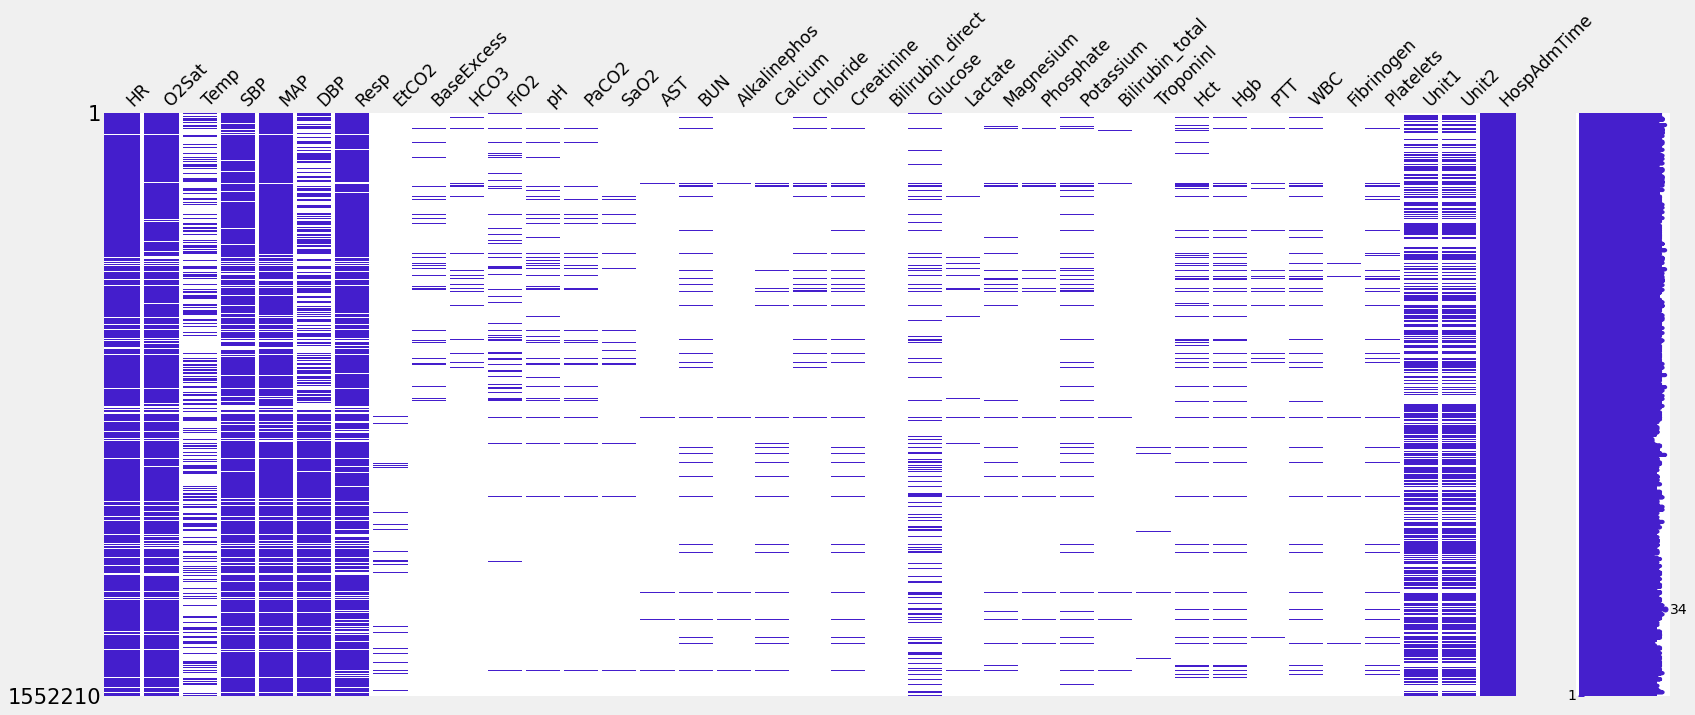

In [12]:
msno.matrix(df[missing_data_col], fontsize=17, color=(0.27, 0.12, 0.8))

<AxesSubplot:>

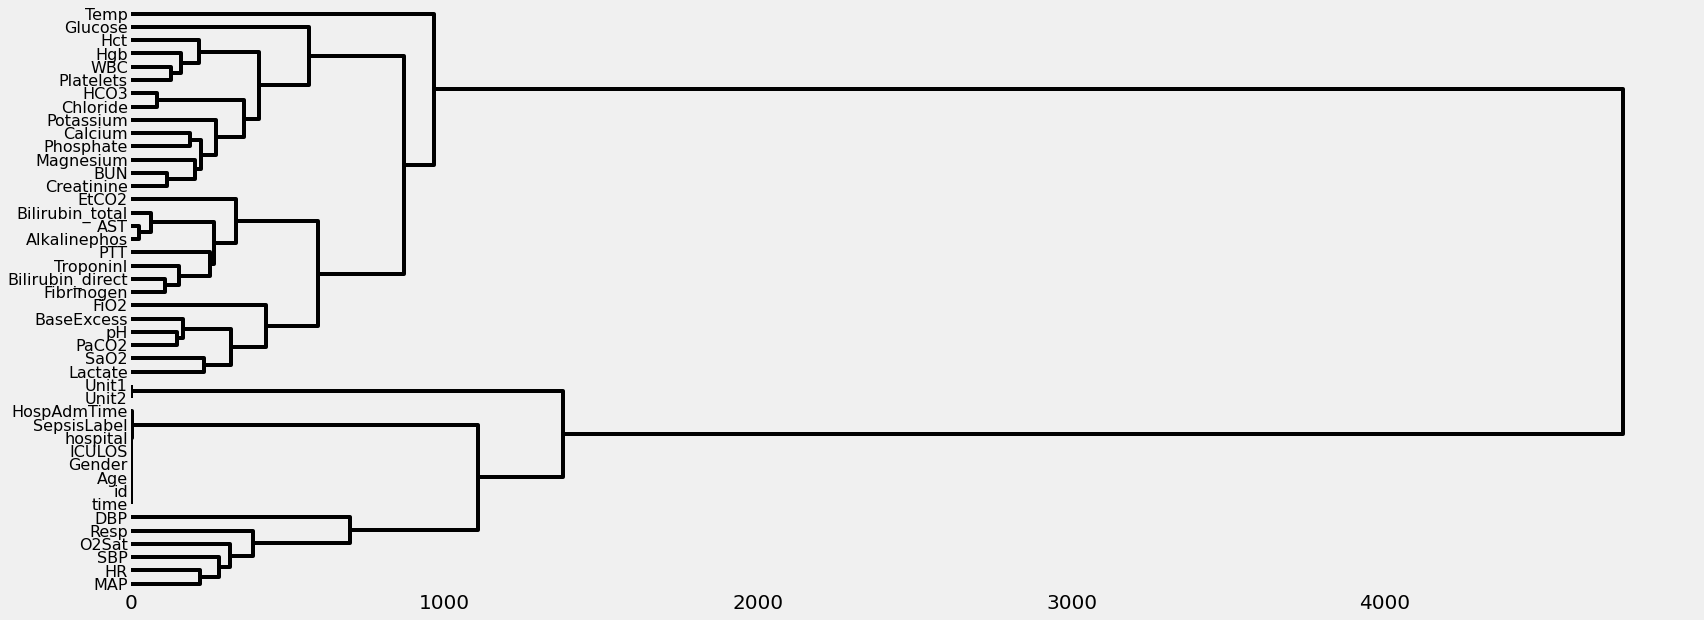

In [13]:
msno.dendrogram(df, orientation="right", method="ward")

Text(0, 0.5, 'Calcium')

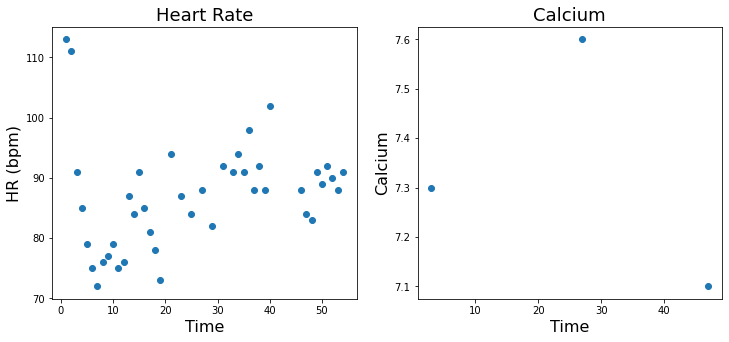

In [3]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Plotting random patient's data
# Get person and time
person = df[df['id'] == 777]
tt = range(person.shape[0])

# Plot HR and
ax[0].scatter(tt, person['HR'])
ax[1].scatter(tt, person['Calcium'])

# Plot info
ax[0].set_title('Heart Rate', fontsize=18)
ax[0].set_xlabel('Time', fontsize=16)
ax[0].set_ylabel('HR (bpm)', fontsize=16)

ax[1].set_title('Calcium', fontsize=18)
ax[1].set_xlabel('Time', fontsize=16)
ax[1].set_ylabel('Calcium', fontsize=16)


### Converting current data to ragged data. the data into a tensor format by extending everyones time-series to the same size as the maximum length time-series in the data filling in all values past the final time as nan.


In [4]:
# The structure keeps track of the original lengths, so we can always convert back, and also keeps track of the columns
# , so we can apply operations only on certain features. This is also going to be very important.

# Load the dataset
dataset = TimeSeriesDataset().load(data_dir + '/raw/data.tsd')
dataset.data.size()

torch.Size([40336, 336, 41])

In [5]:
# 2. Preprocessing Data and Extract Features
dataset.data = torch_ffill(dataset.data)
dataset.data[0,:,0]   # check forward fill

dataset['ShockIndex'] = shock_index(dataset)
dataset['PartialSOFA'] = partial_sofa(dataset)

dataset['MaxShockIndex'] = RollingStatistic(statistic='max', window_length=5).transform(dataset['SBP'])
dataset['MinHR'] = RollingStatistic(statistic='min', window_length=8).transform(dataset['HR'])


<function RollingStatistic.transform at 0x000001A7862DDD30> 
  62.53 ms
<function RollingStatistic.transform at 0x000001A7862DDD30> 
  85.98 ms


C:\Users\Jun Hua\anaconda3\envs\python_gpu\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


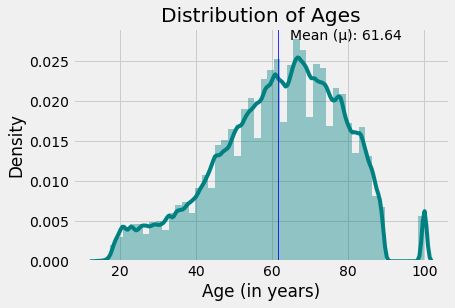

In [6]:
# Get distribution of the ages
plt.style.use("fivethirtyeight")
sns.distplot(dataset['Age'], color='teal', kde=True)
plt.axvline(dataset['Age'].mean(), color='blue', linestyle='-', linewidth=0.8)
min_ylim, max_ylim = plt.ylim()
plt.text(dataset['Age'].mean()*1.05, max_ylim*0.95, 'Mean (μ): {:.2f}'.format(dataset['Age'].mean()))
plt.xlabel("Age (in years)")
plt.title(f"Distribution of Ages")
plt.show()

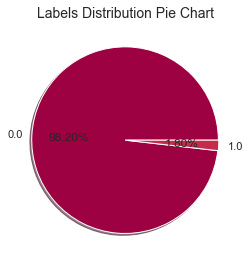

In [14]:
cmap = plt.get_cmap('Spectral')
colors = [cmap(i) for i in np.linspace(0, 1, 15)]

sns.set(style="whitegrid")

labeL_df = pd.DataFrame(labels_binary, columns=['label'])

labels = labeL_df['label'].value_counts().index.tolist()[:2]
values = labeL_df['label'].value_counts().tolist()[:2]

plt.pie(x=values, labels=labels, autopct="%1.2f%%", colors=colors, explode=[0, 0.005], shadow=True)
plt.title("Labels Distribution Pie Chart", fontdict={'fontsize': 14})
plt.show()

In [16]:
# Training Model
# Get ML form of the data
X = dataset.to_ml()
y = labels_binary

assert len(X) == len(y)    # Sanity check

In [ ]:
# Fill the nans
X[torch.isnan(X)] = -1000

# Choose cross val method
cv = list(KFold(5).split(X))

In [ ]:
# Train and predict
clf = RandomForestClassifier()
probas = cross_val_predict(clf, X, y, cv=cv, method='predict_proba')

from sklearn.metrics import accuracy_score, roc_auc_score

preds = (probas[:, 1] > 0.5).astype(int)
acc = accuracy_score(y, preds)
auc = roc_auc_score(y, probas[:, 1])

print('Accuracy: {:.2f}% \nAUC: {:.3f}'.format(round(acc * 100, 2), auc))